In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [3]:
# Get rows at random from the dataset
filename = "LendingClub_data.csv"
n = sum(1 for line in open(filename)) - 1 # number of records in file (excludes header)
s = 100000 # sample size
skip = sorted(random.sample(range(1,n+1),n-s)) # the 0-indexed header will not be included in the skip list
df_ori = pd.read_csv(filename, skiprows=skip)

/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_ori.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
65507,139755998,NaN,40000.0,40000.0,40000.0,60 months,16.14,975.71,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
40487,110006157,NaN,12000.0,12000.0,12000.0,60 months,26.30,361.42,E,E5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
699,67446998,NaN,8650.0,8650.0,8650.0,36 months,18.99,317.04,E,E3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
28680,83923925,NaN,10000.0,10000.0,10000.0,36 months,14.49,344.17,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
95210,120258419,NaN,25500.0,25500.0,25500.0,60 months,11.99,567.11,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
77766,9815016,NaN,10000.0,10000.0,10000.0,60 months,17.57,251.61,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
10553,52658334,NaN,24000.0,24000.0,24000.0,60 months,12.69,542.28,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
57806,12968339,NaN,31450.0,31450.0,31400.0,60 months,23.43,894.38,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
67250,132876672,NaN,8000.0,8000.0,8000.0,36 months,10.56,260.25,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
490,67308457,NaN,6000.0,6000.0,6000.0,36 months,13.67,204.11,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_ori.shape

(100000, 151)

In [6]:
df_ori.dtypes

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

# Preprocessing and Analysis
Only selecting features having less than 30 percent null values in order to reduce the number of features and not have to impute too many values

In [7]:
df_new = df_ori.loc[:, df_ori.isnull().mean() < .30]

In [8]:
df_new.shape

(100000, 93)

Selected relevant features for our use case

In [9]:
cols_to_keep = ["loan_amnt","int_rate", "installment", "home_ownership", "annual_inc", "verification_status", "purpose", "dti", "delinq_2yrs", "fico_range_low", "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "recoveries", "collection_recovery_fee", "application_type", "acc_now_delinq", "tot_cur_bal", "total_rev_hi_lim", "avg_cur_bal", "mort_acc", "pub_rec_bankruptcies", "tax_liens", "loan_status"]

In [10]:
len(cols_to_keep)

28

In [11]:
df = df_new[[col for col in cols_to_keep]]
df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,...,collection_recovery_fee,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,avg_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,loan_status
0,15850.0,23.13,448.01,OWN,45000.0,Not Verified,debt_consolidation,34.85,0.0,755.0,...,0.0000,Individual,0.0,45025.0,41300.0,2649.0,0.0,0.0,0.0,Fully Paid
1,30000.0,15.77,1051.31,MORTGAGE,175000.0,Not Verified,home_improvement,18.50,0.0,725.0,...,0.0000,Individual,0.0,408118.0,43400.0,51015.0,3.0,0.0,0.0,Fully Paid
2,9000.0,9.17,286.92,OWN,50000.0,Not Verified,debt_consolidation,11.98,0.0,800.0,...,0.0000,Individual,0.0,40272.0,15500.0,8054.0,2.0,0.0,0.0,Fully Paid
3,18000.0,7.49,559.83,MORTGAGE,75000.0,Not Verified,debt_consolidation,25.65,0.0,715.0,...,0.0000,Individual,0.0,304914.0,23400.0,25410.0,1.0,0.0,0.0,Fully Paid
4,11550.0,16.59,284.51,RENT,38000.0,Not Verified,credit_card,21.07,0.0,700.0,...,209.7018,Individual,0.0,10353.0,18100.0,1150.0,0.0,0.0,0.0,Charged Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,15000.0,13.49,345.08,RENT,90000.0,Source Verified,debt_consolidation,21.47,0.0,695.0,...,315.3636,Individual,0.0,57746.0,64500.0,3397.0,6.0,0.0,0.0,Charged Off
99996,30000.0,13.99,697.90,MORTGAGE,63500.0,Verified,debt_consolidation,18.45,1.0,690.0,...,0.0000,Individual,0.0,177135.0,8700.0,22142.0,2.0,0.0,0.0,Fully Paid
99997,20000.0,10.99,434.75,MORTGAGE,150000.0,Not Verified,debt_consolidation,9.46,3.0,680.0,...,0.0000,Individual,0.0,204387.0,16100.0,40877.0,3.0,0.0,0.0,Current
99998,12800.0,15.59,308.49,RENT,40000.0,Verified,debt_consolidation,22.71,1.0,695.0,...,0.0000,Individual,0.0,21731.0,15200.0,2415.0,0.0,0.0,0.0,Current


In [12]:
df.dtypes.value_counts()

float64    23
object      5
dtype: int64

In [13]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Charged Off',
       'Does not meet the credit policy. Status:Fully Paid'], dtype=object)

Only kept loans that were either fully paid or charged off, given that these are the only relevant/needed classes to predict

In [14]:
rows_to_rem = df.loc[(df.loan_status != "Fully Paid") & (df.loan_status != "Charged Off")]

In [15]:
df.drop(rows_to_rem.index, inplace=True)

/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loan_status', ylabel='count'>

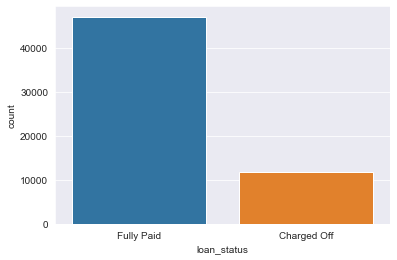

In [16]:
sns.countplot(df.loan_status, data=df)

Looking at the class distribution, we notice there are significantly more fully paid loans than charged off

In [17]:
df.dtypes

loan_amnt                  float64
int_rate                   float64
installment                float64
home_ownership              object
annual_inc                 float64
verification_status         object
purpose                     object
dti                        float64
delinq_2yrs                float64
fico_range_low             float64
fico_range_high            float64
inq_last_6mths             float64
open_acc                   float64
pub_rec                    float64
revol_bal                  float64
revol_util                 float64
total_acc                  float64
recoveries                 float64
collection_recovery_fee    float64
application_type            object
acc_now_delinq             float64
tot_cur_bal                float64
total_rev_hi_lim           float64
avg_cur_bal                float64
mort_acc                   float64
pub_rec_bankruptcies       float64
tax_liens                  float64
loan_status                 object
dtype: object

In [18]:
df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,...,collection_recovery_fee,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,avg_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,loan_status
0,15850.0,23.13,448.01,OWN,45000.0,Not Verified,debt_consolidation,34.85,0.0,755.0,...,0.0000,Individual,0.0,45025.0,41300.0,2649.0,0.0,0.0,0.0,Fully Paid
1,30000.0,15.77,1051.31,MORTGAGE,175000.0,Not Verified,home_improvement,18.50,0.0,725.0,...,0.0000,Individual,0.0,408118.0,43400.0,51015.0,3.0,0.0,0.0,Fully Paid
2,9000.0,9.17,286.92,OWN,50000.0,Not Verified,debt_consolidation,11.98,0.0,800.0,...,0.0000,Individual,0.0,40272.0,15500.0,8054.0,2.0,0.0,0.0,Fully Paid
3,18000.0,7.49,559.83,MORTGAGE,75000.0,Not Verified,debt_consolidation,25.65,0.0,715.0,...,0.0000,Individual,0.0,304914.0,23400.0,25410.0,1.0,0.0,0.0,Fully Paid
4,11550.0,16.59,284.51,RENT,38000.0,Not Verified,credit_card,21.07,0.0,700.0,...,209.7018,Individual,0.0,10353.0,18100.0,1150.0,0.0,0.0,0.0,Charged Off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,16800.0,10.99,365.19,MORTGAGE,150000.0,Not Verified,small_business,25.25,0.0,720.0,...,624.9906,Individual,0.0,268422.0,101200.0,19173.0,1.0,0.0,0.0,Charged Off
99993,22000.0,15.59,769.01,RENT,80000.0,Verified,credit_card,14.51,0.0,660.0,...,0.0000,Individual,0.0,54518.0,35100.0,2596.0,0.0,0.0,0.0,Fully Paid
99995,15000.0,13.49,345.08,RENT,90000.0,Source Verified,debt_consolidation,21.47,0.0,695.0,...,315.3636,Individual,0.0,57746.0,64500.0,3397.0,6.0,0.0,0.0,Charged Off
99996,30000.0,13.99,697.90,MORTGAGE,63500.0,Verified,debt_consolidation,18.45,1.0,690.0,...,0.0000,Individual,0.0,177135.0,8700.0,22142.0,2.0,0.0,0.0,Fully Paid


Given that ML models require numerical values to make sense out of the data and ultimately perform better, I applied label encoding using the category code approach to change all text/categorical values to numerical values

In [19]:
df.home_ownership = df.home_ownership.astype('category')
df["home_ownership_cat"] = df.home_ownership[~df.home_ownership.isnull()].cat.codes

df.verification_status = df.verification_status.astype('category')
df["verification_status_cat"] = df.verification_status[~df.verification_status.isnull()].cat.codes

df.purpose = df.purpose.astype('category')
df["purpose_cat"] = df.purpose[~df.purpose.isnull()].cat.codes

df.application_type = df.application_type.astype('category')
df["application_type_cat"] = df.application_type[~df.application_type.isnull()].cat.codes

df.loan_status = df.loan_status.astype('category')
df["loan_status_cat"] = df.loan_status[~df.loan_status.isnull()].cat.codes


/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/73/635jrw5n4kl5nk9b_plq47bm0000gn/T/ipykernel_9569/2176654696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["home_ownership_cat"] = df.home_ownership[~df.home_ownership.isnull()].cat.codes
/var/folders/73/635jrw5n4kl5nk9b_plq47bm0000gn/T/ipykernel_9569/2176654696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [20]:
cols_to_exclude = ["home_ownership", "verification_status", "purpose", "application_type", "loan_status"]
data = df.loc[:, ~df.columns.isin(cols_to_exclude)]

In [21]:
data

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,...,total_rev_hi_lim,avg_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,home_ownership_cat,verification_status_cat,purpose_cat,application_type_cat,loan_status_cat
0,15850.0,23.13,448.01,45000.0,34.85,0.0,755.0,759.0,1.0,18.0,...,41300.0,2649.0,0.0,0.0,0.0,4,0,2,0,1
1,30000.0,15.77,1051.31,175000.0,18.50,0.0,725.0,729.0,1.0,9.0,...,43400.0,51015.0,3.0,0.0,0.0,1,0,4,0,1
2,9000.0,9.17,286.92,50000.0,11.98,0.0,800.0,804.0,2.0,5.0,...,15500.0,8054.0,2.0,0.0,0.0,4,0,2,0,1
3,18000.0,7.49,559.83,75000.0,25.65,0.0,715.0,719.0,1.0,12.0,...,23400.0,25410.0,1.0,0.0,0.0,1,0,2,0,1
4,11550.0,16.59,284.51,38000.0,21.07,0.0,700.0,704.0,0.0,9.0,...,18100.0,1150.0,0.0,0.0,0.0,5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,16800.0,10.99,365.19,150000.0,25.25,0.0,720.0,724.0,0.0,14.0,...,101200.0,19173.0,1.0,0.0,0.0,1,0,11,0,0
99993,22000.0,15.59,769.01,80000.0,14.51,0.0,660.0,664.0,0.0,21.0,...,35100.0,2596.0,0.0,0.0,0.0,5,2,1,0,1
99995,15000.0,13.49,345.08,90000.0,21.47,0.0,695.0,699.0,1.0,22.0,...,64500.0,3397.0,6.0,0.0,0.0,5,1,2,0,0
99996,30000.0,13.99,697.90,63500.0,18.45,1.0,690.0,694.0,0.0,8.0,...,8700.0,22142.0,2.0,0.0,0.0,1,2,2,0,1


In [22]:
data.isnull().sum()

loan_amnt                     0
int_rate                      0
installment                   0
annual_inc                    0
dti                          19
delinq_2yrs                   0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   39
total_acc                     0
recoveries                    0
collection_recovery_fee       0
acc_now_delinq                0
tot_cur_bal                2929
total_rev_hi_lim           2929
avg_cur_bal                2929
mort_acc                   2020
pub_rec_bankruptcies         30
tax_liens                     0
home_ownership_cat            0
verification_status_cat       0
purpose_cat                   0
application_type_cat          0
loan_status_cat               0
dtype: int64

Filling all missing values with a simple statistic such as the mean may not result in the most optimal performance when the data is used for training. I opted to use the K-Nearest Neighbours algorithm as this uses a distance metric to determine a specified set of nearest neighbours and imputes the mean value for those neighbours

In [23]:
knn_imputer = KNNImputer(n_neighbors=3)
knn_np = knn_imputer.fit_transform(data)

In [24]:
data_imputed = pd.DataFrame(knn_np, columns = data.columns)
data_imputed

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,...,total_rev_hi_lim,avg_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,home_ownership_cat,verification_status_cat,purpose_cat,application_type_cat,loan_status_cat
0,15850.0,23.13,448.01,45000.0,34.85,0.0,755.0,759.0,1.0,18.0,...,41300.0,2649.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0
1,30000.0,15.77,1051.31,175000.0,18.50,0.0,725.0,729.0,1.0,9.0,...,43400.0,51015.0,3.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0
2,9000.0,9.17,286.92,50000.0,11.98,0.0,800.0,804.0,2.0,5.0,...,15500.0,8054.0,2.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0
3,18000.0,7.49,559.83,75000.0,25.65,0.0,715.0,719.0,1.0,12.0,...,23400.0,25410.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
4,11550.0,16.59,284.51,38000.0,21.07,0.0,700.0,704.0,0.0,9.0,...,18100.0,1150.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58696,16800.0,10.99,365.19,150000.0,25.25,0.0,720.0,724.0,0.0,14.0,...,101200.0,19173.0,1.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0
58697,22000.0,15.59,769.01,80000.0,14.51,0.0,660.0,664.0,0.0,21.0,...,35100.0,2596.0,0.0,0.0,0.0,5.0,2.0,1.0,0.0,1.0
58698,15000.0,13.49,345.08,90000.0,21.47,0.0,695.0,699.0,1.0,22.0,...,64500.0,3397.0,6.0,0.0,0.0,5.0,1.0,2.0,0.0,0.0
58699,30000.0,13.99,697.90,63500.0,18.45,1.0,690.0,694.0,0.0,8.0,...,8700.0,22142.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0


In [25]:
data_imputed.isnull().sum()

loan_amnt                  0
int_rate                   0
installment                0
annual_inc                 0
dti                        0
delinq_2yrs                0
fico_range_low             0
fico_range_high            0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
recoveries                 0
collection_recovery_fee    0
acc_now_delinq             0
tot_cur_bal                0
total_rev_hi_lim           0
avg_cur_bal                0
mort_acc                   0
pub_rec_bankruptcies       0
tax_liens                  0
home_ownership_cat         0
verification_status_cat    0
purpose_cat                0
application_type_cat       0
loan_status_cat            0
dtype: int64

In [26]:
x = data_imputed[data_imputed.columns[:-1]]
y = data_imputed["loan_status_cat"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

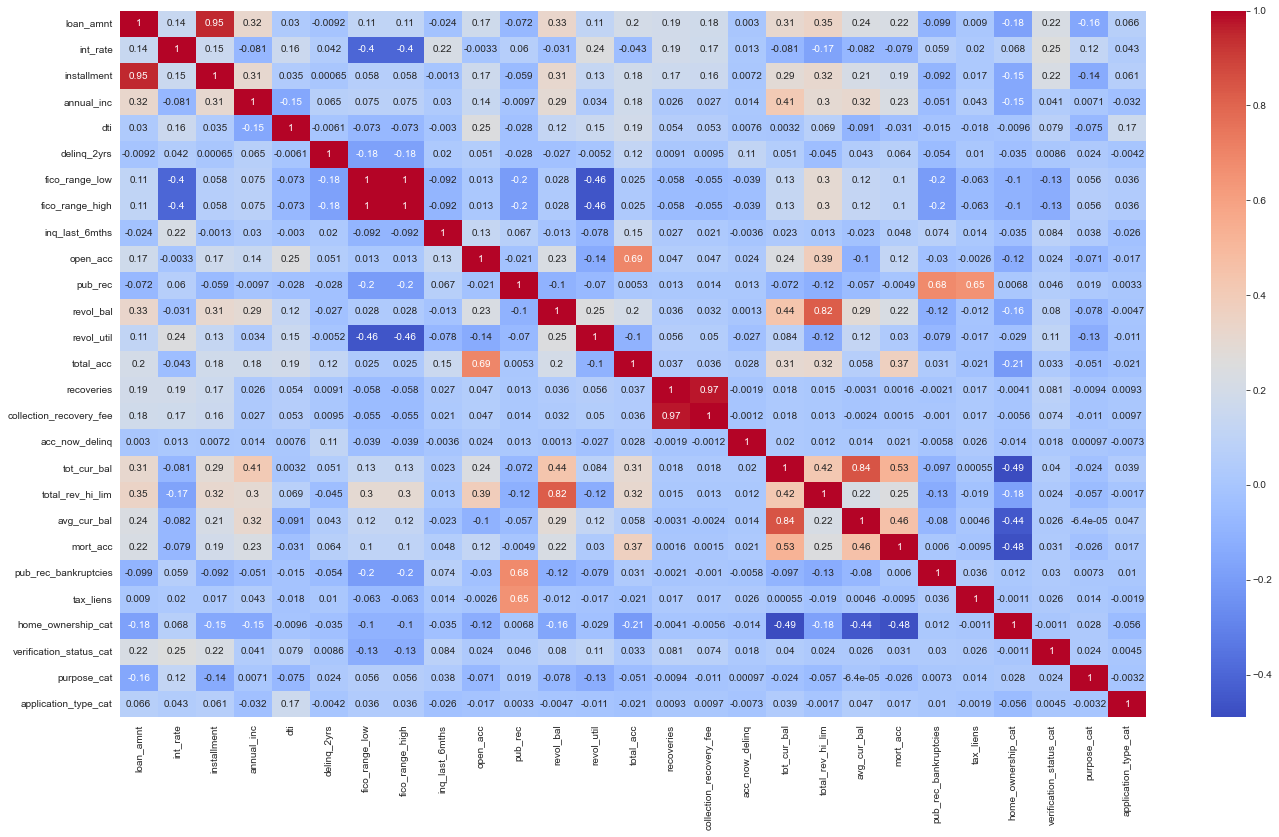

In [27]:
plt.figure(figsize=(23,13))
cor = x_train.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

There are many features with very high correlations. Strong correlations between features may cause a noisy signal in the prediction model, which makes it difficult to determine which features are more important to the predictions. As a result, features with high correlations will be dropped

In [28]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [29]:
corr_features = correlation(x_train, 0.7)
len(set(corr_features))

5

In [30]:
corr_features

{'avg_cur_bal',
 'collection_recovery_fee',
 'fico_range_high',
 'installment',
 'total_rev_hi_lim'}

In [31]:
x_train.shape

(46960, 27)

Features with above 70% correlations are removed

In [32]:
x_train.drop(corr_features, axis=1, inplace=True)
x_test.drop(corr_features, axis=1, inplace=True)

/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
x_train.shape

(46960, 22)

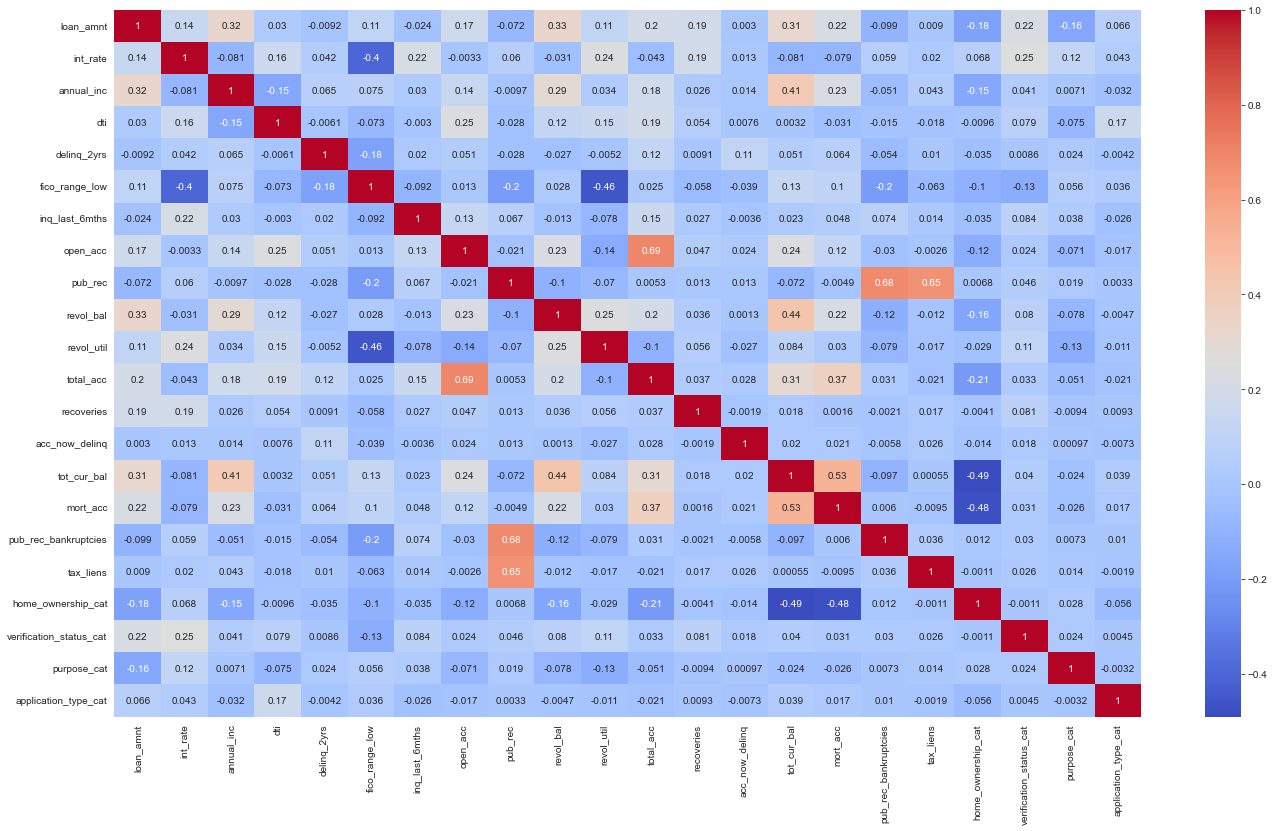

In [34]:
plt.figure(figsize=(23,13))
sns.heatmap(x_train.corr(), annot=True, cmap='coolwarm')
plt.show()

## Handling Outliers

I chose to handle outliers after the train test split so that when testing the data, it would be given a fair assessment, as the test data would resemble what we would receive in a production environment

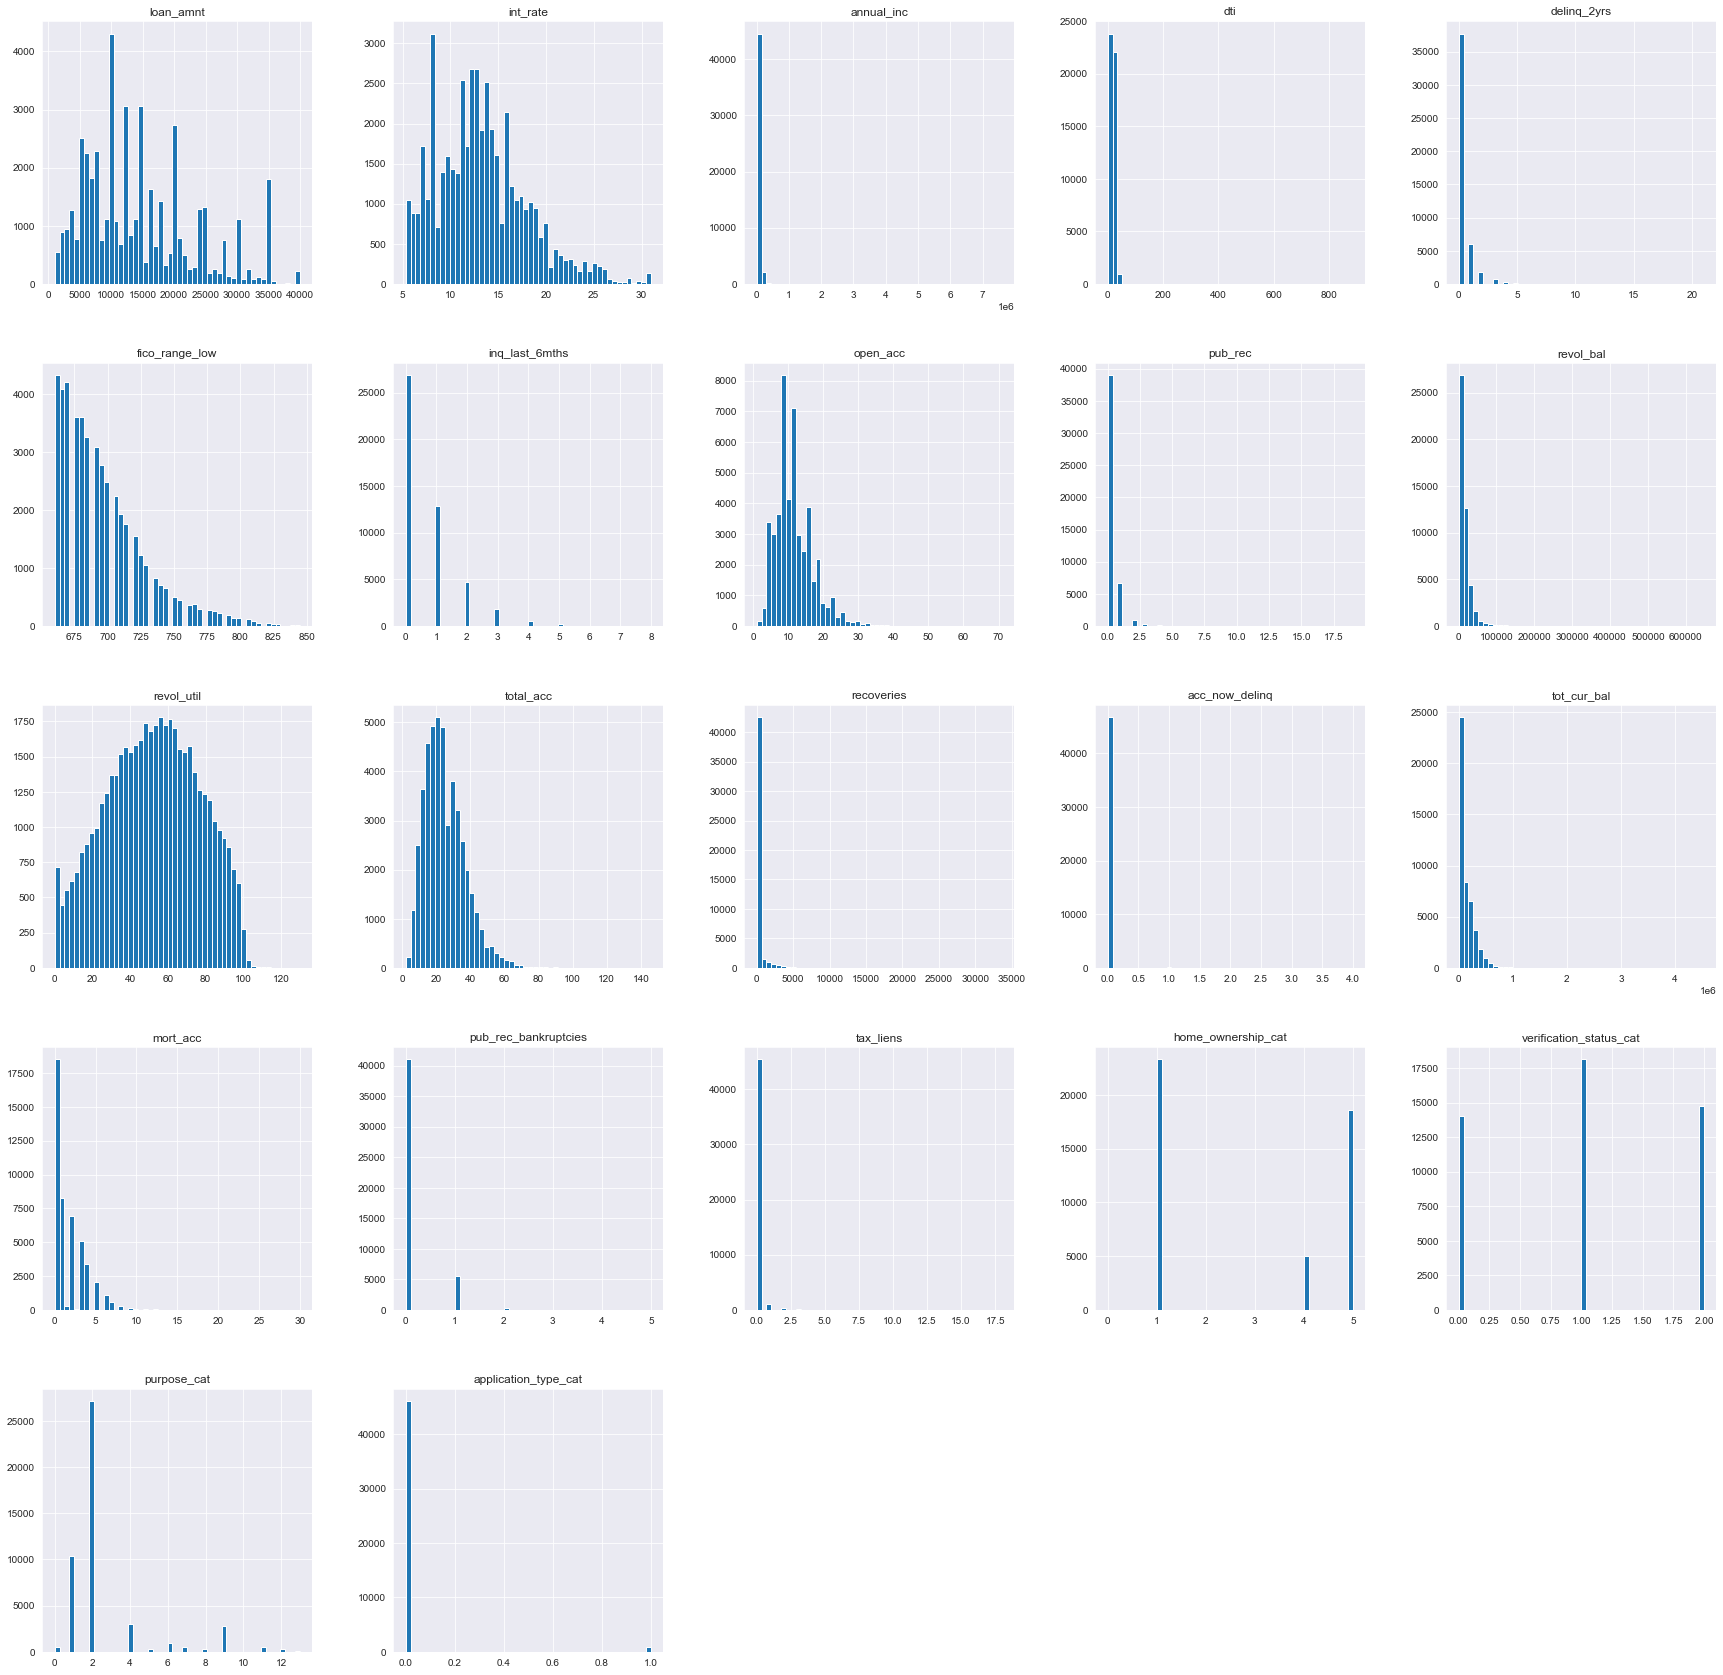

In [35]:
x_train.hist(figsize = (30, 30), bins = 50, legend = False)
plt.show()

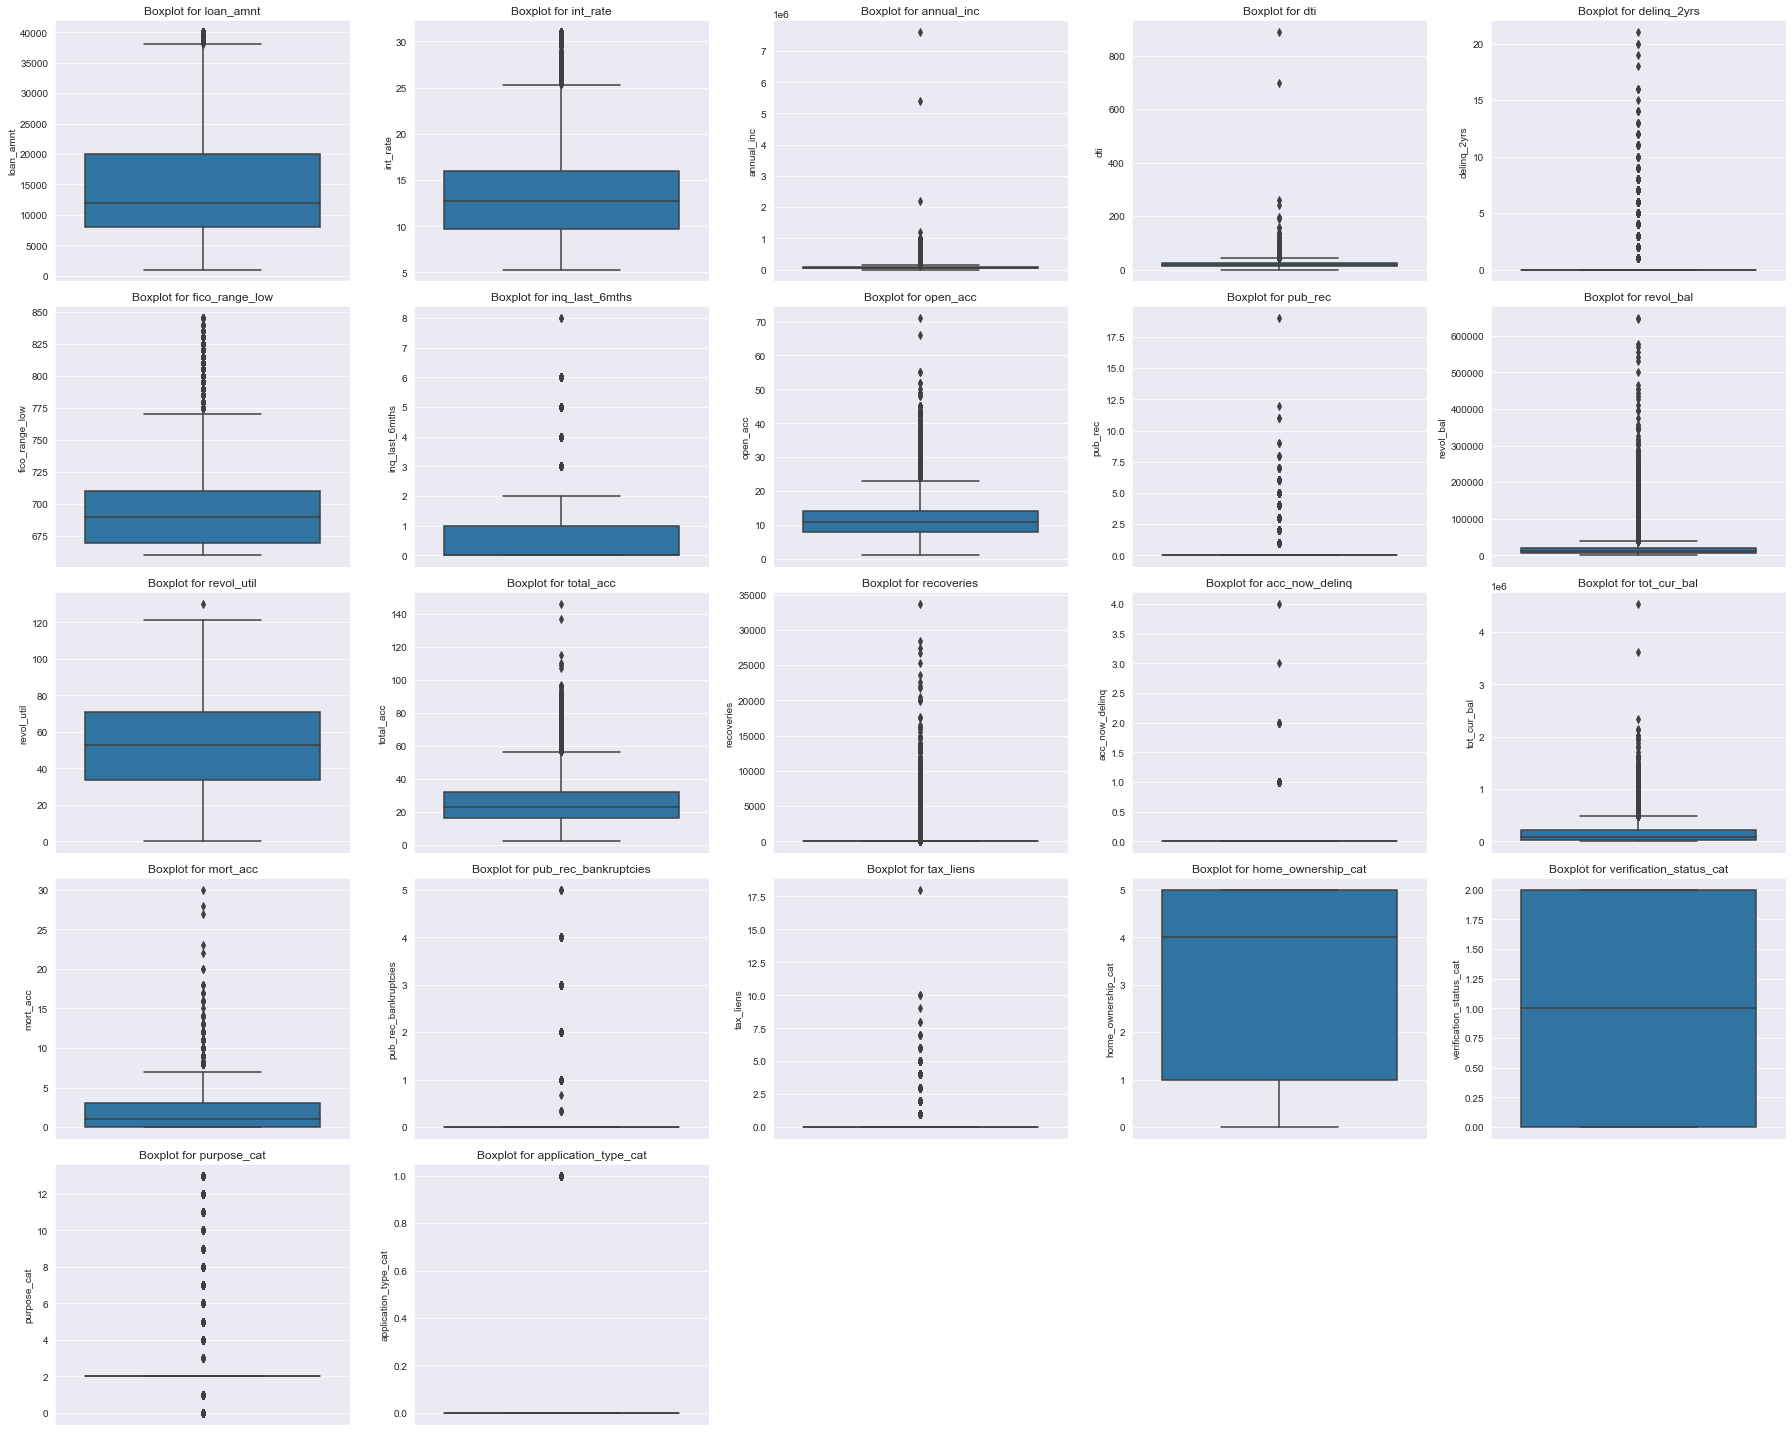

In [36]:
plt.figure(figsize = (25, 20))

def bx_plot(df, a, var):

    ax = plt.subplot(5, 5, a+1)
    sns.boxplot(y = df[var])
    ax.set_title(f"Boxplot for {var}")
    plt.tight_layout()

for i, col in enumerate(x_train):
    bx_plot(x_train, i, col)

Looking at the histograms, we notice that some features contain outliers (as seen on in the boxplots) because they are positively skewed

In [37]:
x_train

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,...,recoveries,acc_now_delinq,tot_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,home_ownership_cat,verification_status_cat,purpose_cat,application_type_cat
45012,8000.0,19.52,65000.0,8.92,0.0,670.0,2.0,9.0,1.0,9274.0,...,0.00,0.0,13011.0,0.0,1.0,0.0,5.0,1.0,4.0,0.0
45635,8400.0,9.99,36000.0,8.07,2.0,660.0,0.0,7.0,0.0,5984.0,...,0.00,0.0,10093.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0
42292,28000.0,11.44,130000.0,16.20,0.0,700.0,0.0,13.0,0.0,28478.0,...,1500.00,0.0,447302.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
49972,17000.0,8.90,110000.0,4.84,1.0,665.0,0.0,7.0,0.0,13936.0,...,0.00,0.0,212556.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
10960,6125.0,13.99,43000.0,31.96,0.0,710.0,0.0,15.0,0.0,13302.0,...,0.00,0.0,243972.0,3.0,0.0,0.0,1.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,12000.0,15.61,37000.0,19.36,0.0,695.0,1.0,10.0,0.0,7327.0,...,2.75,0.0,157122.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0
52416,8000.0,12.79,36500.0,22.00,0.0,685.0,0.0,12.0,0.0,9609.0,...,0.00,0.0,30173.0,0.0,0.0,0.0,5.0,2.0,2.0,0.0
42613,15000.0,16.99,77000.0,2.99,0.0,725.0,0.0,3.0,0.0,3237.0,...,0.00,0.0,505706.0,2.0,0.0,0.0,1.0,2.0,2.0,1.0
43567,20000.0,12.74,85000.0,17.75,0.0,665.0,0.0,9.0,0.0,23144.0,...,0.00,0.0,46035.0,3.0,0.0,0.0,4.0,2.0,2.0,0.0


In [38]:
qt_transformer = QuantileTransformer(output_distribution = "uniform")
x_train_tran = qt_transformer.fit_transform(x_train)
x_test_tran = qt_transformer.transform(x_test)

x_train = pd.DataFrame(x_train_tran, columns = x_train.columns)
x_test = pd.DataFrame(x_test_tran, columns = x_test.columns)

x_train

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,...,recoveries,acc_now_delinq,tot_cur_bal,mort_acc,pub_rec_bankruptcies,tax_liens,home_ownership_cat,verification_status_cat,purpose_cat,application_type_cat
0,0.266767,0.903403,0.503003,0.148815,0.000000,0.223223,0.895896,0.359359,0.900901,0.419610,...,0.000000,0.0,0.087593,0.000000,0.933433,0.0,1.000000,0.492492,0.841842,0.0
1,0.289790,0.272272,0.121121,0.121872,0.952953,0.000000,0.000000,0.190691,0.000000,0.251303,...,0.000000,0.0,0.061267,0.000000,0.000000,0.0,1.000000,0.000000,0.121622,0.0
2,0.904404,0.367367,0.910410,0.439773,0.000000,0.641642,0.000000,0.673674,0.000000,0.868118,...,0.942431,0.0,0.955824,0.649650,0.000000,0.0,0.248749,0.000000,0.121622,0.0
3,0.675175,0.196697,0.848849,0.046046,0.868869,0.135135,0.000000,0.190691,0.000000,0.604542,...,0.000000,0.0,0.754044,0.484985,0.000000,0.0,0.248749,0.000000,0.121622,0.0
4,0.188438,0.612112,0.207708,0.935936,0.000000,0.736737,0.000000,0.780781,0.000000,0.583980,...,0.000000,0.0,0.801447,0.779279,0.000000,0.0,0.248749,1.000000,0.520521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46955,0.480981,0.729730,0.130130,0.575576,0.000000,0.585586,0.708709,0.447447,0.000000,0.321255,...,0.865748,0.0,0.653174,0.649650,0.000000,0.0,0.248749,1.000000,0.520521,0.0
46956,0.266767,0.504004,0.127127,0.679642,0.000000,0.456456,0.000000,0.607107,0.000000,0.434994,...,0.000000,0.0,0.251363,0.000000,0.000000,0.0,1.000000,1.000000,0.520521,0.0
46957,0.598098,0.797297,0.633634,0.020937,0.000000,0.840340,0.000000,0.010010,0.000000,0.108749,...,0.000000,0.0,0.971207,0.649650,0.000000,0.0,0.248749,1.000000,0.520521,1.0
46958,0.758759,0.498498,0.702703,0.507508,0.000000,0.135135,0.000000,0.359359,0.000000,0.806872,...,0.000000,0.0,0.367401,0.779279,0.000000,0.0,0.550050,1.000000,0.520521,0.0


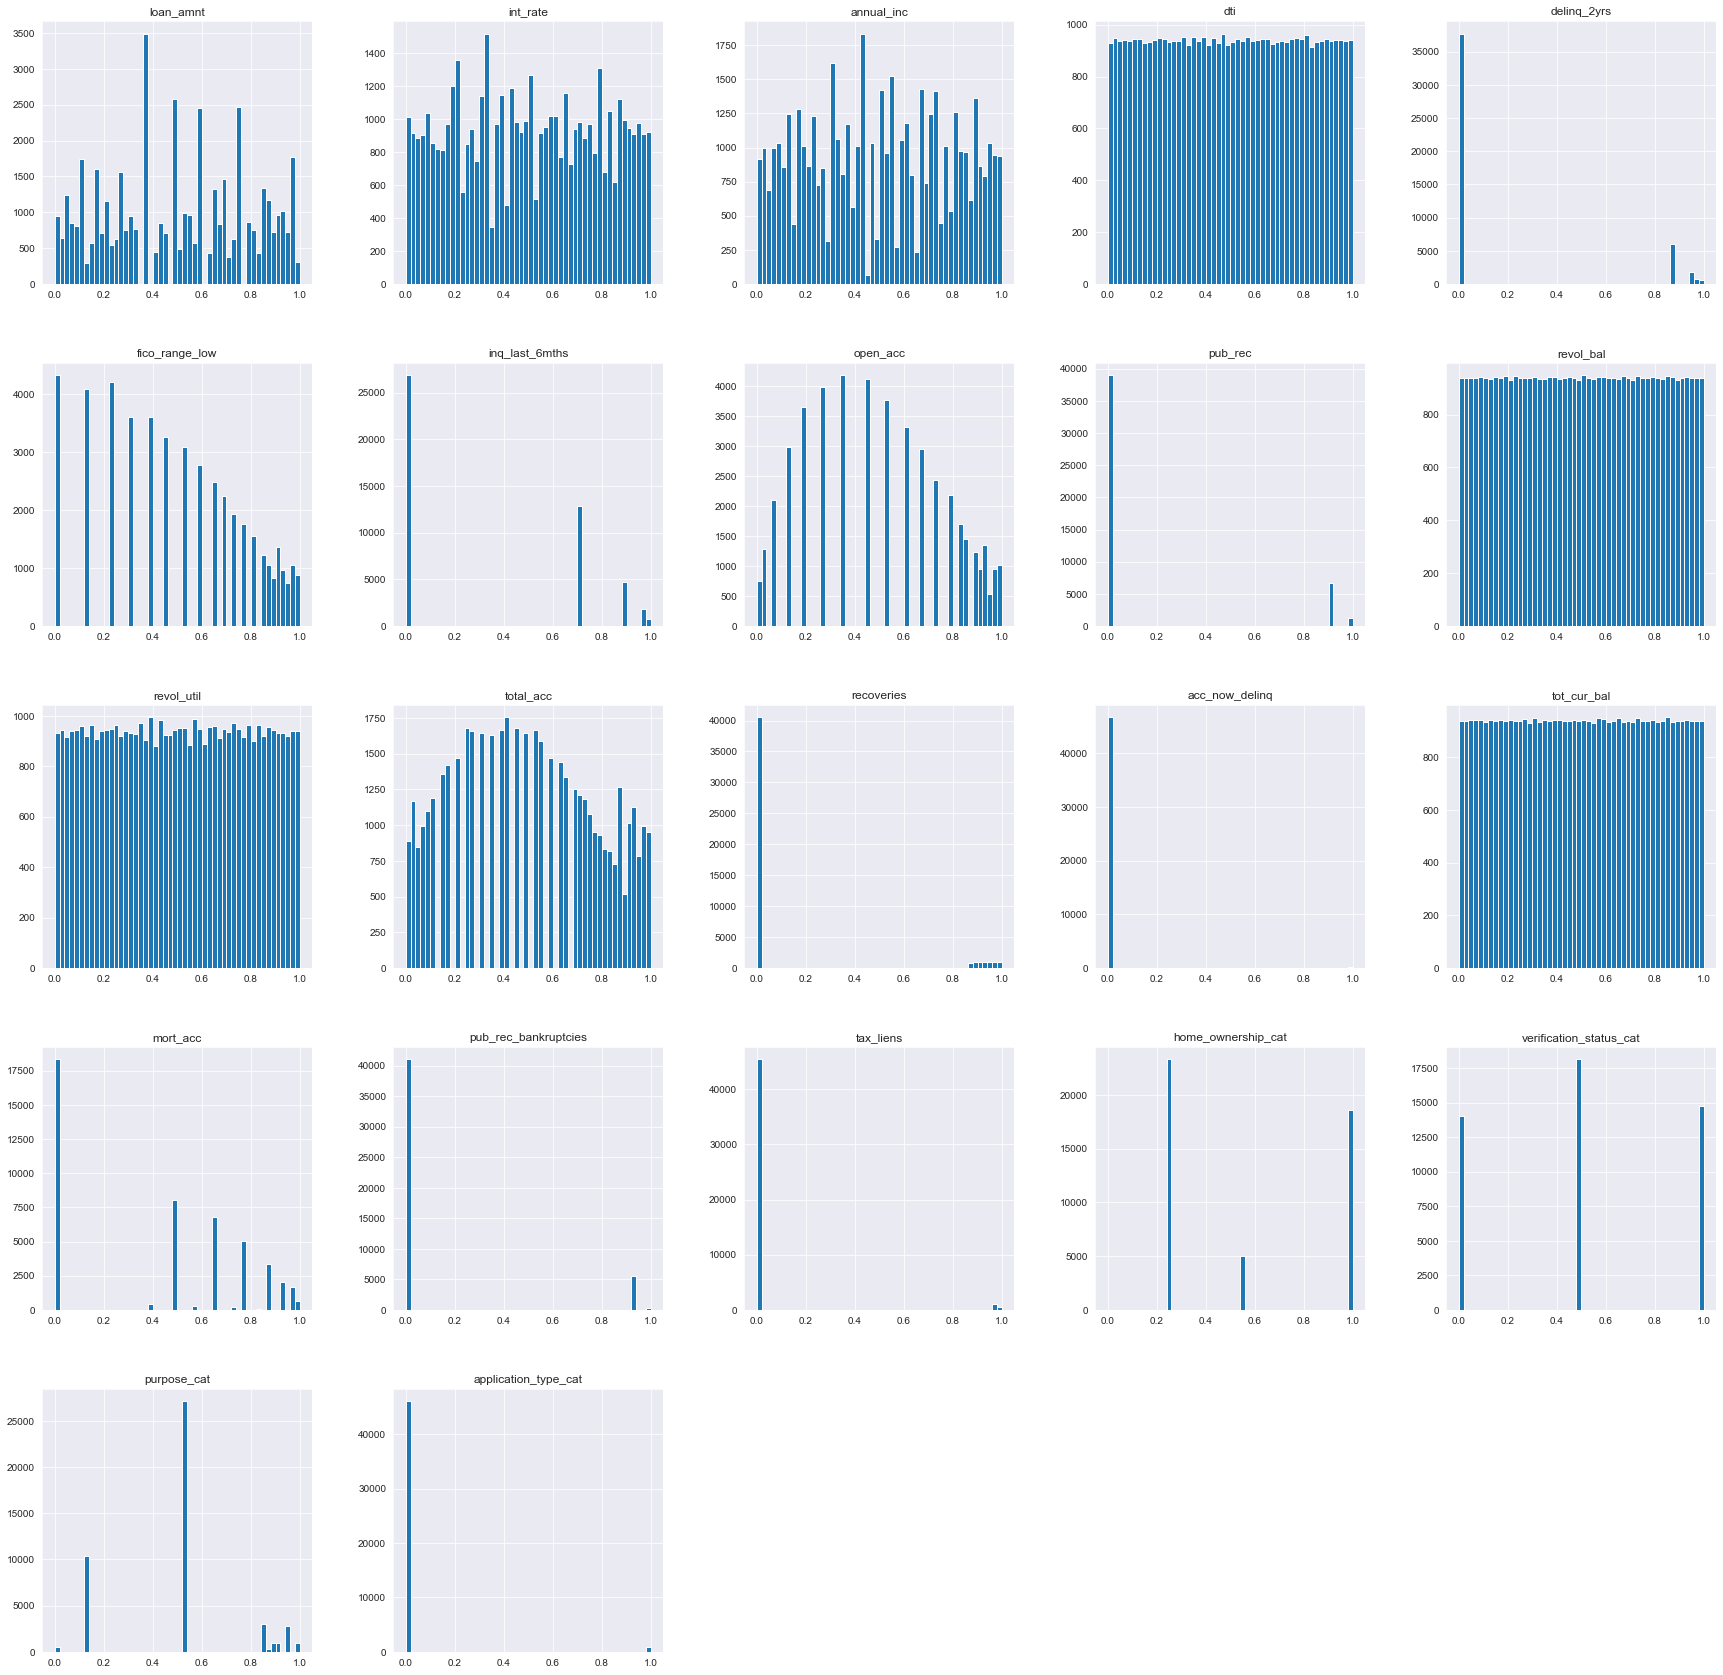

In [39]:
x_train.hist(figsize = (30, 30), bins = 50, legend = False)
plt.show()

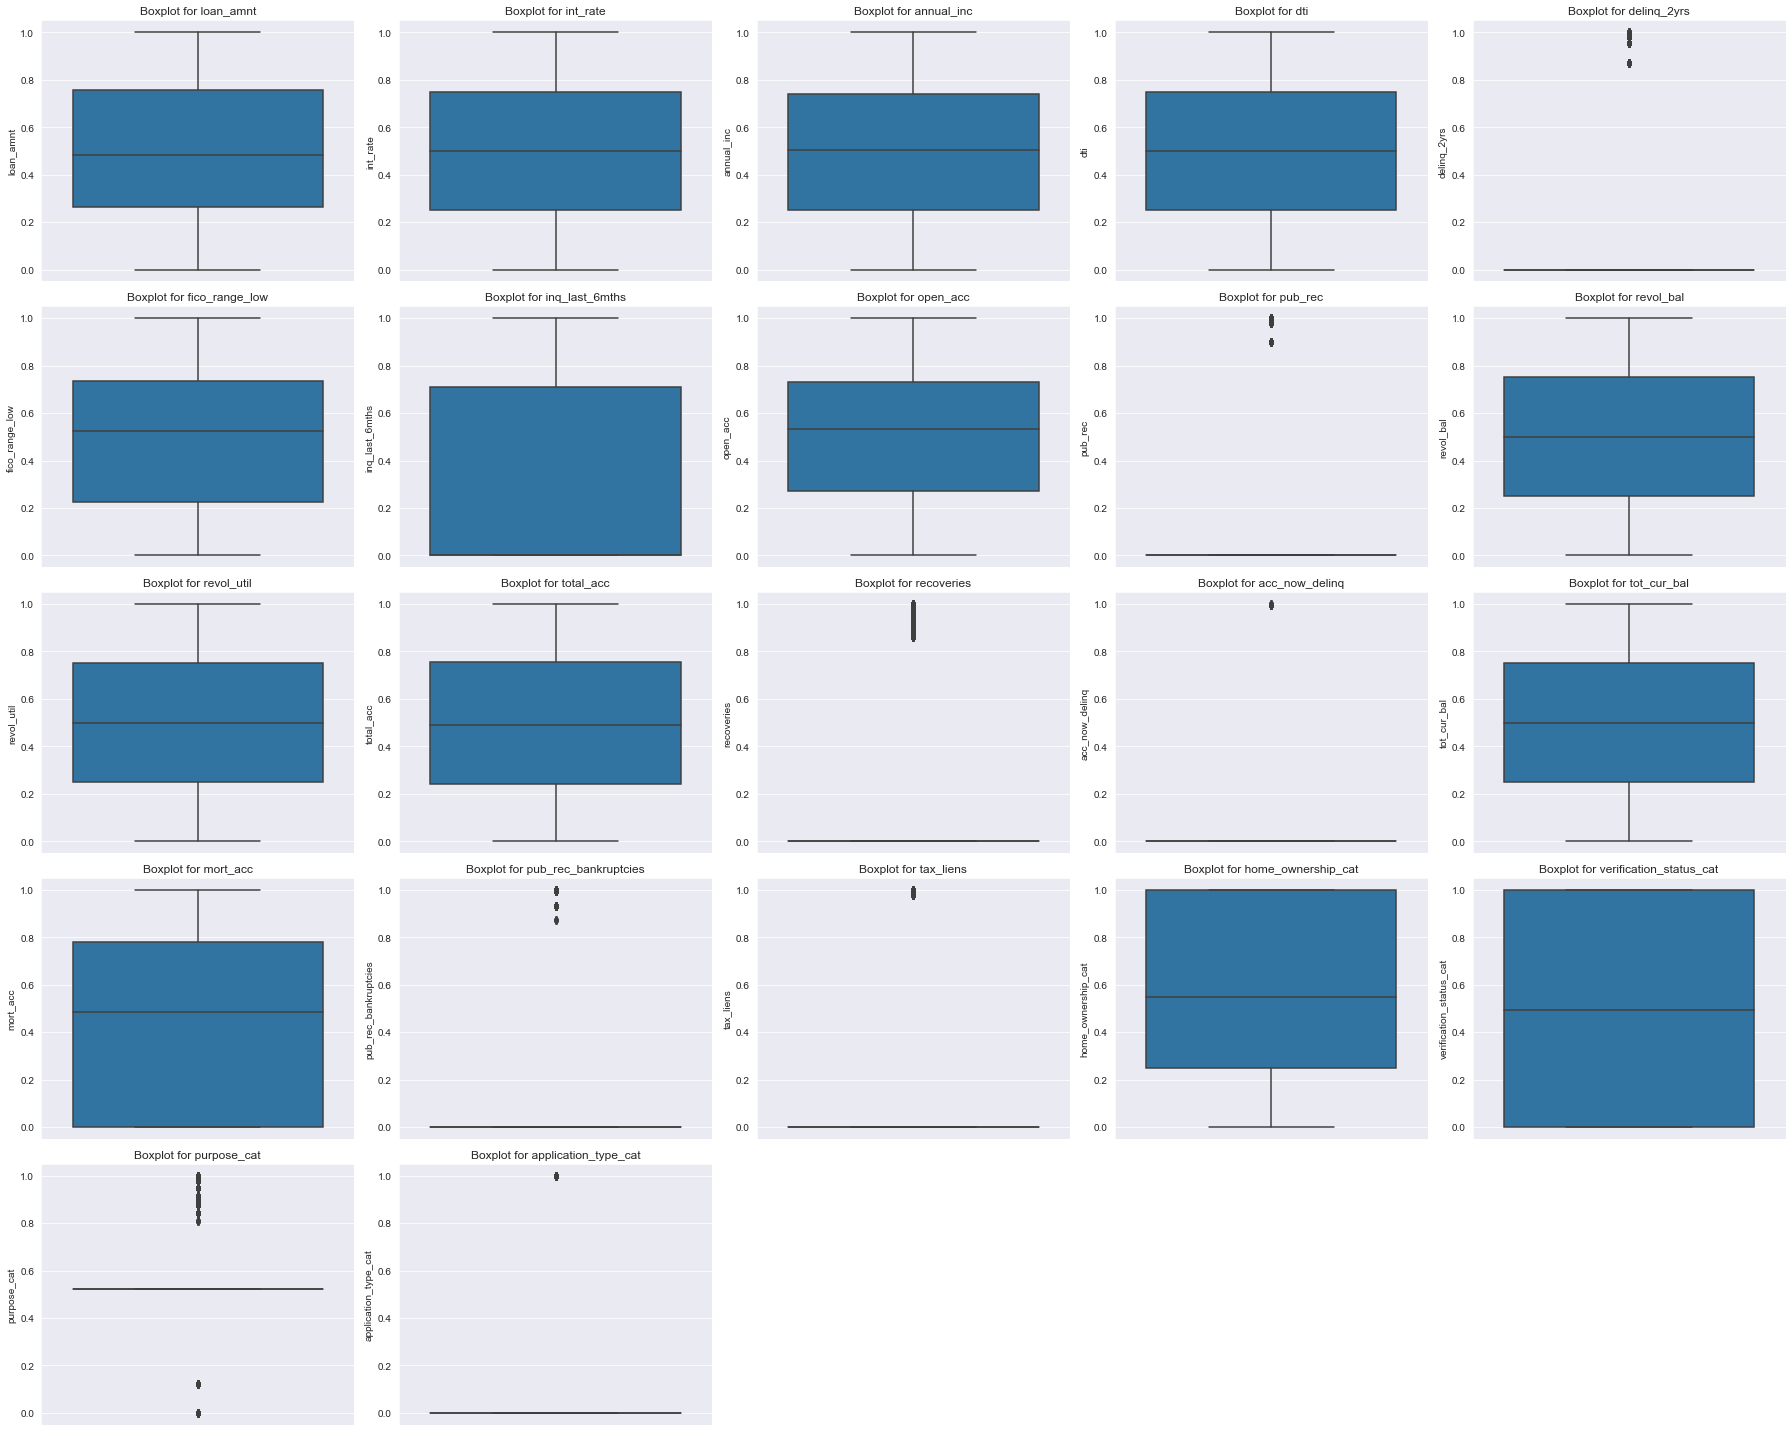

In [40]:
plt.figure(figsize = (25, 20))

def bx_plot(df, a, var):

    ax = plt.subplot(5, 5, a+1)
    sns.boxplot(y = df[var])
    ax.set_title(f"Boxplot for {var}")
    plt.tight_layout()

for i, col in enumerate(x_train):
    bx_plot(x_train, i, col)

# Model Training

### Random Forest

In [41]:
rf = RandomForestClassifier(max_features=10, n_estimators=200, class_weight="balanced")
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=10,
                       n_estimators=200)

### Naive Bayes

In [42]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

### KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

### Logistic Regression

In [44]:
log_reg = LogisticRegression(multi_class="auto", max_iter=1000, class_weight="balanced")
log_reg.fit(x_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Prediction Probabilities

In [45]:
r_probs = [0 for _ in range(len(y_test))]
rf_probs = rf.predict_proba(x_test)
nb_probs = nb.predict_proba(x_test)
knn_probs = knn.predict_proba(x_test)
logr_probs = log_reg.predict_proba(x_test)

In [46]:
rf_probs = rf_probs[:, 1]
nb_probs = nb_probs[:, 1]
knn_probs = knn_probs[:, 1]
logr_probs = logr_probs[:, 1]

In [47]:
r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
logr_auc = roc_auc_score(y_test, logr_probs)

## AUROC Scores

In [48]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Naive Bayes: AUROC = %.3f' % (nb_auc))
print('KNN: AUROC = %.3f' % (knn_auc))
print('Logistic Regression: AUROC = %.3f' % (logr_auc))

Random (chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.898
Naive Bayes: AUROC = 0.897
KNN: AUROC = 0.860
Logistic Regression: AUROC = 0.902


# ROC Curve & PR Curve

In [49]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
logr_fpr, logr_tpr, _ = roc_curve(y_test, logr_probs)

In [50]:
precision_logr, recall_logr, threshold_logr = precision_recall_curve(y_test, logr_probs)
auc_logr = auc(recall_logr, precision_logr)

precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_test, rf_probs)
auc_rf = auc(recall_rf, precision_rf)

print(f"Logistic Regression PR: {auc_logr} \nRandom Forest PR: {auc_rf}")

Logistic Regression PR: 0.9630573215276739 
Random Forest PR: 0.9602094551020975


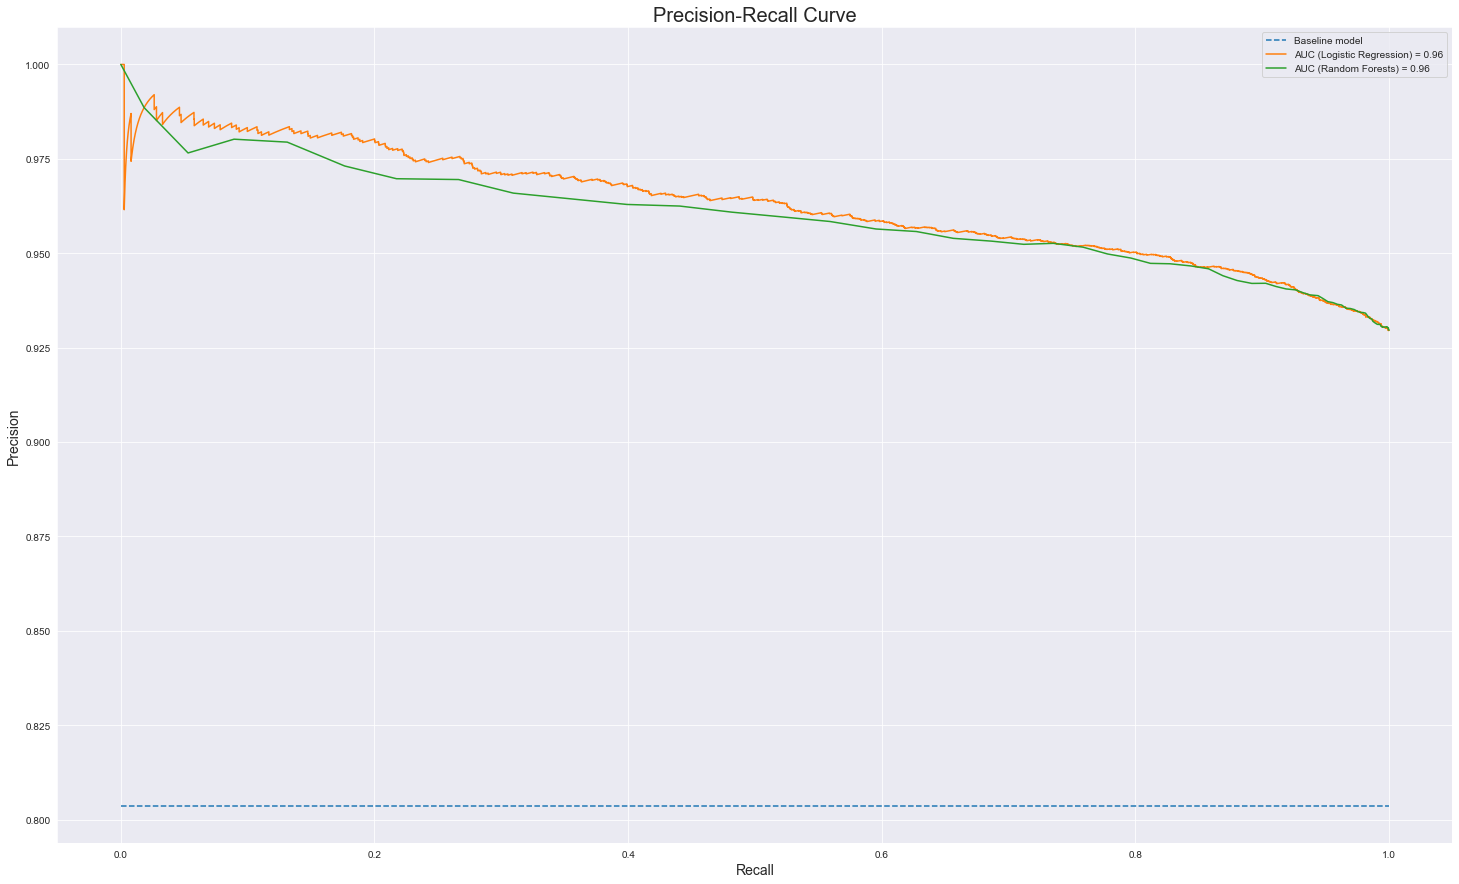

In [51]:
baseline_model = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize=(25, 15))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')
plt.plot(recall_logr, precision_logr, label=f'AUC (Logistic Regression) = {auc_logr:.2f}')
plt.plot(recall_rf, precision_rf, label=f'AUC (Random Forests) = {auc_rf:.2f}')

plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();

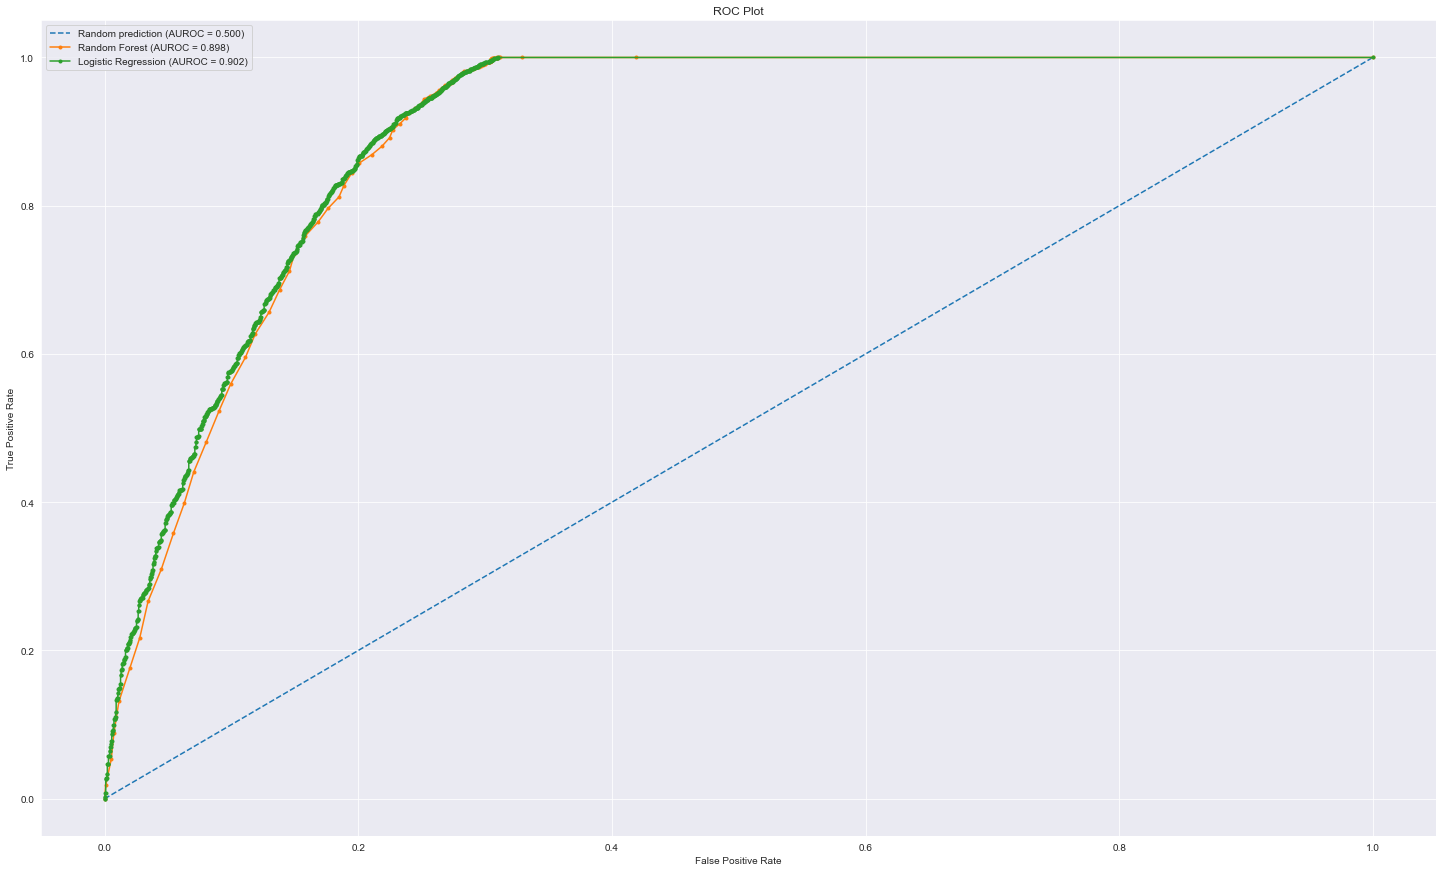

In [52]:
plt.figure(figsize = (25, 15))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
#plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
#plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % knn_auc)
plt.plot(logr_fpr, logr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % logr_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

/Users/ivanfranck/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='loan_status_cat', ylabel='count'>

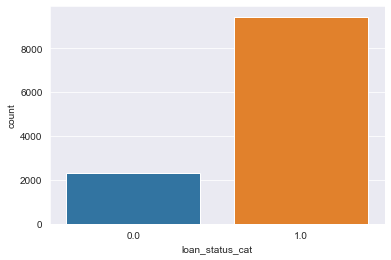

In [53]:
sns.countplot(y_test)

Score:  0.9391874627374159
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.82      2305
         1.0       0.93      1.00      0.96      9436

    accuracy                           0.94     11741
   macro avg       0.96      0.85      0.89     11741
weighted avg       0.94      0.94      0.93     11741



Text(0.5, 1.0, 'Accuracy Score: 0.9391874627374159')

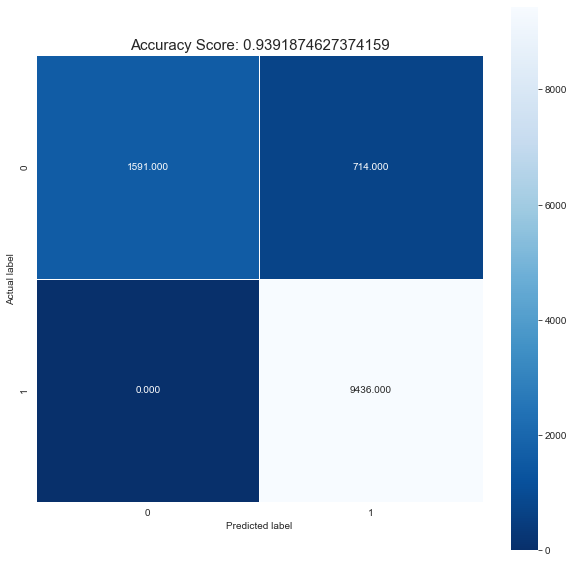

In [54]:
score_rf = rf.score(x_test, y_test)
print("Score: ", score_rf)
pred_rf = rf.predict(x_test)
print(classification_report(y_test, pred_rf))
cm_rf = metrics.confusion_matrix(y_test, pred_rf)


plt.figure(figsize=(10,10))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {score_rf}'
plt.title(all_sample_title, size = 15)

In [55]:
pd.DataFrame({'Label':y_test,'Predictions':pred_rf}).sample(10)

,Label,Predictions
15269,0.0,0.0
32923,0.0,0.0
26351,0.0,0.0
32272,1.0,1.0
52660,1.0,1.0
47957,1.0,1.0
7288,0.0,0.0
14854,1.0,1.0
21294,1.0,1.0
52039,1.0,1.0


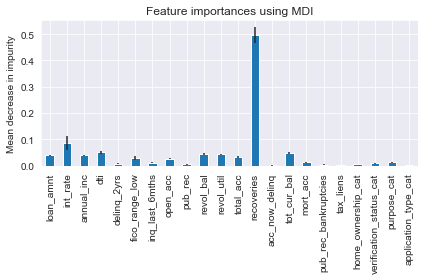

In [56]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Score:  0.9277744655480794
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80      2305
         1.0       0.93      0.98      0.96      9436

    accuracy                           0.93     11741
   macro avg       0.91      0.85      0.88     11741
weighted avg       0.93      0.93      0.92     11741



Text(0.5, 1.0, 'Accuracy Score: 0.9277744655480794')

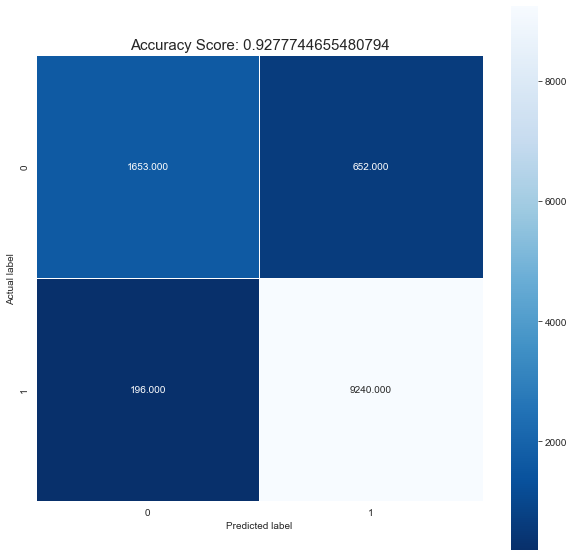

In [57]:
score_logr = log_reg.score(x_test, y_test)
print("Score: ", score_logr)
pred_logr = log_reg.predict(x_test)
print(classification_report(y_test, pred_logr))
cm_logr = metrics.confusion_matrix(y_test, pred_logr)


plt.figure(figsize=(10,10))
sns.heatmap(cm_logr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {score_logr}'
plt.title(all_sample_title, size = 15)

In [58]:
pd.DataFrame({'Label':y_test,'Predictions':pred_logr}).sample(10)

,Label,Predictions
18764,1.0,1.0
19585,1.0,1.0
29291,1.0,1.0
26183,1.0,1.0
28564,1.0,1.0
22633,1.0,1.0
17719,1.0,1.0
56140,1.0,1.0
21480,1.0,1.0
9198,0.0,0.0


## Cross Validation Scores

In [59]:
score_lr = cross_val_score(log_reg, x_train, y_train,cv=10)
print(score_lr)
print("Avg :", np.average(score_lr))


[0.92568143 0.93249574 0.92717206 0.9246167  0.92270017 0.92695911
 0.92844974 0.92482964 0.92738501 0.93015332]
Avg : 0.9270442930153321


In [60]:
score_rf = cross_val_score(rf,x_train, y_train,cv=10)
print(score_rf)
print("Avg :", np.average(score_rf))

[0.94143952 0.94186542 0.93888416 0.93483816 0.93568995 0.93824532
 0.94143952 0.93739353 0.93462521 0.93867121]
Avg : 0.938309199318569


# Conclusion

Both the Random Forest and Logistic regression models performed well. There was better performance after the data was uniformly scaled and also when the models had a balanced class weight to work with. Overall, the Logistic Regression model slightly outperformed the Random Forest model.